In [1]:
import torch
from pyqcu.ascend import dslash
from pyqcu.ascend.include import *
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 16, 16)
# latt_size = (16, 16, 16, 32)
latt_size = (16, 16, 16, 16)
# latt_size = (16, 16, 8, 8)
# latt_size = (8, 16, 16, 32)
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 32, 64)
# latt_size = (4, 8, 8, 8)
# latt_size = (8, 8, 8, 4)
# latt_size = (16, 8, 8, 8)
# latt_size = (8, 8, 8, 16)
# latt_size = (8, 8, 8, 8)
# latt_size = (4, 4, 4, 4)
# latt_size = (2, 2, 2, 2)
# mass = -3.5
# mass = -0.8
# mass = -0.5
# mass = 0.05
# mass = 0.0
mass = -0.05
# kappa = 0.4
# kappa = 0.125
# kappa = 0.5
kappa = 1 / (2 * mass + 8)
dtype = torch.complex128
# dtype = torch.complex64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Initialize lattice gauge theory
wilson = dslash.wilson_mg(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
clover = dslash.clover(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
U = wilson.generate_gauge_field(sigma=0.1, seed=42)

wilson.check_su3(U)
clover_term = clover.make_clover(U=U)
clover_term = torch.zeros_like(clover_term) # just for test

b = torch.randn(4, 3, latt_size[3], latt_size[2], latt_size[1], latt_size[0],
                dtype=dtype, device=device)
verbose = True

Using device: cuda


In [2]:
hopping_plus_list = []
hopping_minus_list = []
for ward in range(4):
    hopping_plus_list.append(wilson.give_hopping_plus(ward=ward, U=U))
    hopping_minus_list.append(wilson.give_hopping_minus(ward=ward, U=U))
Ab = wilson.give_wilson(src=b, U=U, with_I=False)
_Ab = torch.zeros_like(b)
for ward in range(4):
    _Ab += wilson.give_wilson_plus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_plus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
    _Ab += wilson.give_wilson_minus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_minus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
print(torch.norm(Ab-_Ab).item()/torch.norm(Ab).item())

2.1730434272736335e-16


In [3]:
from pyqcu.ascend import inverse
mg = inverse.mg(b=b, wilson=wilson, U=U,
                clover=clover, clover_term=clover.add_I(clover_term=clover_term), verbose=verbose, max_iter=50, max_levels=2)

self.dof_list:[12, 24, 24, 24, 24, 4, 4, 24, 12, 12, 12, 24, 24, 24, 24, 48, 48, 24, 8, 8, 8, 4, 12, 12, 12, 8, 4, 2, 4, 4, 24, 12, 12, 12, 4, 4, 4, 4, 4]
Building grid list:
  Level 0: 16x16x16x16
  Level 1: 8x8x8x8
self.grid_list:[[16, 16, 16, 16], [8, 8, 8, 8]]
Norm of b:992.4258022666642
Norm of r:1404.3245609028654
Norm of x0:887.5565947550829
BICGSTAB-Iteration 0: Residual = 2.422057e+02, Time = 0.052551 s
BICGSTAB-Iteration 1: Residual = 7.944479e+01, Time = 0.050651 s
BICGSTAB-Iteration 2: Residual = 1.343315e+02, Time = 0.049730 s
BICGSTAB-Iteration 3: Residual = 2.662248e+01, Time = 0.049419 s
BICGSTAB-Iteration 4: Residual = 1.722147e+01, Time = 0.050619 s
BICGSTAB-Iteration 5: Residual = 1.189987e+01, Time = 0.052838 s
BICGSTAB-Iteration 6: Residual = 9.613864e+00, Time = 0.049930 s
BICGSTAB-Iteration 7: Residual = 1.941930e+01, Time = 0.049471 s
BICGSTAB-Iteration 8: Residual = 9.564476e+00, Time = 0.049395 s
BICGSTAB-Iteration 9: Residual = 7.232343e+00, Time = 0.049388 s

In [4]:
def matvec(src: torch.Tensor, U: torch.Tensor = U, clover_term: torch.Tensor = clover_term) -> torch.Tensor:
    return wilson.give_wilson(src, U)+clover.give_clover(clover_term=clover_term, src=src)


def _matvec(src: torch.Tensor) -> torch.Tensor:
    return mg.op_list[0].matvec(src=src)

In [5]:
%%time
%time Ab = matvec(b)
%time _Ab = _matvec(b)
print(torch.norm(U).item())
print(torch.norm(clover_term).item())
print(torch.norm(Ab).item())
print(torch.norm(_Ab).item())
print(torch.norm(Ab-_Ab).item()/torch.norm(_Ab).item())

CPU times: user 3.48 ms, sys: 0 ns, total: 3.48 ms
Wall time: 3.14 ms
CPU times: user 1.56 ms, sys: 0 ns, total: 1.56 ms
Wall time: 1.44 ms


886.8100134752651
0.0
994.3538675727694
994.3538675727694
1.398270027691132e-16
CPU times: user 266 ms, sys: 2 μs, total: 266 ms
Wall time: 265 ms


In [6]:
%time Ab = matvec(b)
%time _Ab = _matvec(b)

CPU times: user 3.78 ms, sys: 0 ns, total: 3.78 ms
Wall time: 3.7 ms
CPU times: user 1.98 ms, sys: 0 ns, total: 1.98 ms
Wall time: 2.14 ms


In [7]:
b0 = mg.b_list[0]
b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=b0)
_b0 = inverse.prolong(local_ortho_null_vecs=mg.lonv_list[0], coarse_vec=b1)
_b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=_b0)
print(_b1.flatten()[:100]/b1.flatten()[:100])

restrict:shape,coarse_dof:(torch.Size([24, 12, 8, 2, 8, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
prolong:shape,fine_dof:(torch.Size([24, 12, 8, 2, 8, 2, 8, 2, 8, 2]), 12)
EeTtZzYyXx,ETZYX->eTtZzYyXx
restrict:shape,coarse_dof:(torch.Size([24, 12, 8, 2, 8, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
tensor([1.0000-7.1605e-16j, 1.0000-1.0726e-16j, 1.0000-2.1279e-16j,
        1.0000-5.4574e-18j, 1.0000+1.4952e-17j, 1.0000+7.0949e-17j,
        1.0000-1.9317e-16j, 1.0000+5.3045e-17j, 1.0000-8.0557e-16j,
        1.0000-1.7040e-18j, 1.0000+3.8045e-16j, 1.0000-1.8184e-16j,
        1.0000-5.1884e-16j, 1.0000+2.4666e-16j, 1.0000-2.7003e-17j,
        1.0000-2.2985e-17j, 1.0000-1.1378e-16j, 1.0000+1.6290e-16j,
        1.0000+1.0723e-16j, 1.0000-2.7593e-16j, 1.0000-2.0202e-16j,
        1.0000+3.9717e-17j, 1.0000+3.0370e-15j, 1.0000+5.4318e-17j,
        1.0000+3.5603e-18j, 1.0000+1.8467e-16j, 1.0000+1.1291e-17j,
        1.0000-1.4293e-16j, 1.0000-8.4535e-17j, 1.0000+4.6513e-16j,
        

In [8]:
# _x = inverse.cg(b=b, matvec=matvec, verbose=verbose)
_x = inverse.bicgstab(b=b, matvec=_matvec, verbose=verbose)
# _x = inverse.bicgstab(b=b, matvec=mg.op_list[0].matvec, verbose=verbose)

Norm of b:887.1781621292079
Norm of r:1332.4212564389454
Norm of x0:886.472311805698
BICGSTAB-Iteration 0: Residual = 2.870245e+02, Time = 0.051925 s
BICGSTAB-Iteration 1: Residual = 1.203672e+02, Time = 0.051688 s
BICGSTAB-Iteration 2: Residual = 1.310619e+02, Time = 0.052213 s
BICGSTAB-Iteration 3: Residual = 7.776663e+01, Time = 0.052054 s
BICGSTAB-Iteration 4: Residual = 4.866970e+01, Time = 0.052091 s
BICGSTAB-Iteration 5: Residual = 3.872020e+01, Time = 0.051730 s
BICGSTAB-Iteration 6: Residual = 2.916514e+01, Time = 0.052160 s
BICGSTAB-Iteration 7: Residual = 2.971628e+01, Time = 0.051783 s
BICGSTAB-Iteration 8: Residual = 1.366853e+02, Time = 0.052296 s
BICGSTAB-Iteration 9: Residual = 5.658211e+01, Time = 0.051626 s
BICGSTAB-Iteration 10: Residual = 3.284733e+01, Time = 0.052428 s
BICGSTAB-Iteration 11: Residual = 5.406663e+01, Time = 0.051842 s
BICGSTAB-Iteration 12: Residual = 3.808866e+01, Time = 0.052283 s
BICGSTAB-Iteration 13: Residual = 1.795309e+01, Time = 0.052908 s
B

MG-0:Norm of b:887.1781621292079
MG-0:Norm of r:1331.674024093071
MG-0:Norm of x0:887.0743538489878
B-MG-0-BICGSTAB-Iteration 0: Residual = 2.870995e+02
restrict:shape,coarse_dof:(torch.Size([24, 12, 8, 2, 8, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
MG-1:Norm of b:154.49920221861555
MG-1:Norm of r:269.4131416379225
MG-1:Norm of x0:313.8958971381744
B-MG-1-BICGSTAB-Iteration 0: Residual = 6.353885e+01
F-MG-1-BICGSTAB-Iteration 0: Residual = 6.353885e+01, Time = 0.012660 s
B-MG-1-BICGSTAB-Iteration 1: Residual = 2.985903e+01
F-MG-1-BICGSTAB-Iteration 1: Residual = 2.985903e+01, Time = 0.012482 s
B-MG-1-BICGSTAB-Iteration 2: Residual = 1.949286e+01
F-MG-1-BICGSTAB-Iteration 2: Residual = 1.949286e+01, Time = 0.012400 s
B-MG-1-BICGSTAB-Iteration 3: Residual = 1.283019e+02
F-MG-1-BICGSTAB-Iteration 3: Residual = 1.283019e+02, Time = 0.012411 s
B-MG-1-BICGSTAB-Iteration 4: Residual = 1.663956e+01
F-MG-1-BICGSTAB-Iteration 4: Residual = 1.663956e+01, Time = 0.012507 s
B-MG-1-BICGSTAB-

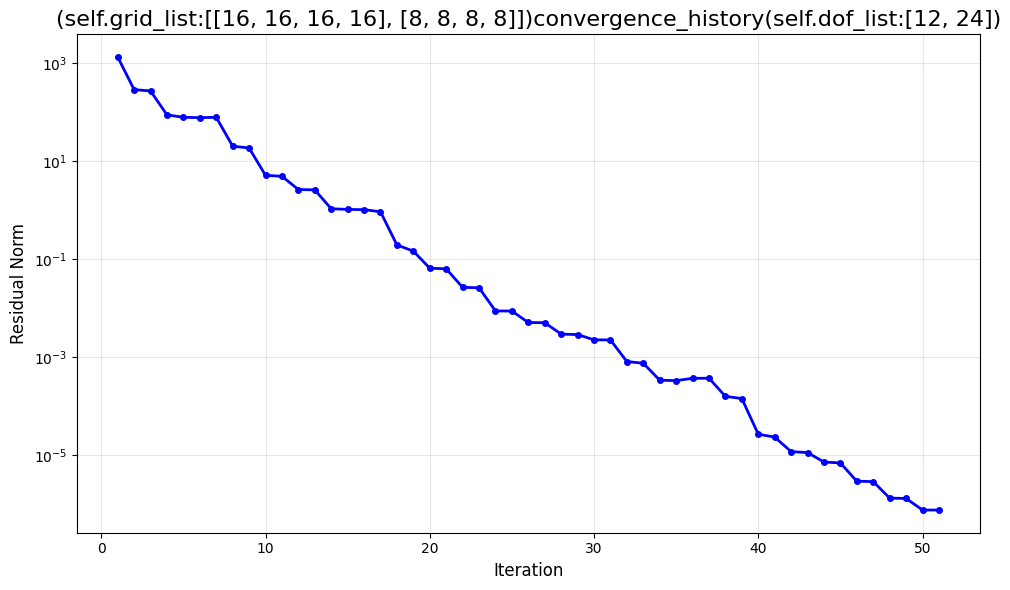

In [9]:
mg.max_iter=200
mg.convergence_history=[]
x = mg.solve()
mg.plot()

In [10]:
mg.lonv_list[0].shape

torch.Size([24, 12, 8, 2, 8, 2, 8, 2, 8, 2])

In [11]:
(mg.b_list[0]-mg.op_list[0].matvec(x.reshape([12]+list(x.shape[-4:])))).flatten()[:100]

tensor([ 3.4572e-11+1.0818e-12j,  1.0570e-09-2.5662e-10j,
         5.9410e-10-1.0720e-10j,  7.6052e-10+6.3548e-10j,
         2.6135e-10+7.6775e-11j,  8.6847e-10-3.3208e-10j,
         3.7300e-10-4.3971e-10j,  2.1031e-10-1.9201e-10j,
        -5.5379e-10+7.2499e-10j,  2.6391e-10+5.5362e-10j,
        -4.0345e-10+9.7697e-10j, -1.5082e-10-1.9455e-10j,
        -3.3715e-10+5.2470e-11j, -5.6522e-10+8.0164e-11j,
        -1.0757e-10-6.1138e-10j, -4.8603e-11+5.5481e-10j,
        -8.2816e-10+2.2251e-10j, -4.6901e-10-3.6341e-10j,
        -1.3296e-10-6.7796e-11j, -1.6814e-09+1.4160e-12j,
        -7.6411e-10+4.0435e-10j, -1.7009e-10+1.0280e-09j,
         7.0201e-10+1.6021e-11j, -2.6305e-10+1.1546e-09j,
         5.9292e-10-2.6019e-11j,  2.3061e-11+5.6243e-10j,
        -5.2553e-10+1.0432e-10j,  3.3343e-11-3.9350e-10j,
         3.7782e-10-8.8449e-11j, -3.2093e-10-5.1593e-10j,
        -4.5732e-10-5.3580e-10j,  1.1561e-10+6.4539e-10j,
        -1.9709e-10+1.6041e-10j, -5.5125e-10-8.6691e-10j,
        -3.319

In [12]:
print(torch.norm(x-_x).item()/torch.norm(_x).item())

6.449254554977711e-09


In [13]:
mg.num_levels

2

In [14]:
index = 0
null_vecs = mg.nv_list[index]
matvec = mg.op_list[index].matvec
for i in range(null_vecs.shape[0]):
    print(
        f"(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:{(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]}")

(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0081-3.8866e-05j, 0.0057+4.3134e-02j, 0.0019-1.8240e-03j,
        0.0227+2.4059e-02j, 0.0117-4.8686e-03j, 0.0141+2.7458e-02j,
        0.0108+5.0166e-03j, 0.0230+1.8860e-02j, 0.0109-9.1551e-03j,
        0.0182+7.1639e-03j], device='cuda:0', dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0118-0.0086j, 0.0082-0.0113j, 0.0124-0.0105j, 0.0071-0.0094j,
        0.0125-0.0065j, 0.0069-0.0069j, 0.0124-0.0069j, 0.0107-0.0061j,
        0.0148-0.0067j, 0.0138-0.0054j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0130-0.0338j, 0.0247-0.0290j, 0.0432-0.0439j, 0.0204-0.0597j,
        0.0319-0.0720j, 0.0471-0.1040j, 0.0385-0.0968j, 0.0525-0.1236j,
        0.0629-0.1111j, 0.0324-0.0935j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0088-0.0064j, 0.0138-0.0015j, 0.0085-0.0034j, 

In [15]:
mg.nv_list[-1].flatten()[:100]

tensor([-0.0007+3.6069e-04j, -0.0006+2.8176e-04j, -0.0007+4.8878e-04j,
        -0.0007+4.6711e-04j, -0.0009+3.3887e-04j, -0.0008+5.4142e-04j,
        -0.0008+4.6992e-04j, -0.0006+4.7898e-04j, -0.0007+2.5034e-04j,
        -0.0010+1.9257e-04j, -0.0008+5.0947e-04j, -0.0007+3.3852e-04j,
        -0.0008+3.0371e-04j, -0.0006+3.2384e-04j, -0.0007+4.4098e-04j,
        -0.0007+3.8713e-04j, -0.0008+3.0882e-04j, -0.0008+3.0668e-04j,
        -0.0007+3.7743e-04j, -0.0007+2.4832e-04j, -0.0009+2.8063e-04j,
        -0.0008+4.0436e-04j, -0.0010+5.1504e-04j, -0.0009+3.8509e-04j,
        -0.0007+3.2564e-04j, -0.0009+1.4021e-04j, -0.0008+3.3416e-04j,
        -0.0006+3.5387e-04j, -0.0009+3.3724e-04j, -0.0007+2.6002e-04j,
        -0.0007+2.6664e-04j, -0.0006+2.7646e-04j, -0.0008+1.4848e-04j,
        -0.0009+3.0003e-04j, -0.0007+4.8683e-04j, -0.0008+4.8507e-04j,
        -0.0009+5.0843e-04j, -0.0007+3.5511e-04j, -0.0009+5.6307e-04j,
        -0.0009+3.9719e-04j, -0.0009+3.4816e-04j, -0.0007+2.4100e-04j,
      

In [16]:
_null_vec = torch.randn_like(null_vecs[0])
print(torch.norm(matvec(_null_vec)))
print(matvec(_null_vec).flatten()[:20])
_null_vec -= inverse.bicgstab(b=matvec(_null_vec), matvec=matvec, tol=5e-5)
print(torch.norm(_null_vec))
print(_null_vec.flatten()[:20])
_null_vec/=torch.norm(_null_vec).item()
print(
    f"(matvec(_null_vec)/_null_vec).flatten()[:10]:{(matvec(_null_vec)/_null_vec).flatten()[:10]}")

tensor(993.6393, device='cuda:0', dtype=torch.float64)
tensor([ 0.4381+1.5562j, -0.5711+0.8626j, -0.7152-0.9736j,  0.7699-0.2733j,
        -0.0188-0.7990j, -0.8914+0.7299j, -0.5199+0.3778j,  1.4477-0.6891j,
        -1.2435+0.3572j, -0.4716+1.3632j, -1.0909+0.1500j, -0.0449-0.9603j,
         1.9748-0.1647j, -0.9708-0.1609j,  1.0385-0.6272j, -0.4155-0.2934j,
         0.2526-0.1638j, -0.7168-0.9726j,  0.2128-0.4279j, -0.3704+0.4404j],
       device='cuda:0', dtype=torch.complex128)
Norm of b:993.6392541479526
Norm of r:1403.7441026031004
Norm of x0:887.012646082572
BICGSTAB-Iteration 0: Residual = 2.422423e+02, Time = 0.053631 s
BICGSTAB-Iteration 1: Residual = 7.925766e+01, Time = 0.052630 s
BICGSTAB-Iteration 2: Residual = 1.311177e+02, Time = 0.051968 s
BICGSTAB-Iteration 3: Residual = 2.635456e+01, Time = 0.051948 s
BICGSTAB-Iteration 4: Residual = 1.710201e+01, Time = 0.051480 s
BICGSTAB-Iteration 5: Residual = 1.161409e+01, Time = 0.052843 s
BICGSTAB-Iteration 6: Residual = 9.293071

In [17]:
_b = torch.randn_like(null_vecs[0])
_x = inverse.bicgstab(b=_b, matvec=matvec, tol=1e-8)
print((_b-matvec(_x)).flatten()[:100])
print(torch.norm(_b))
print(torch.norm(_x))

Norm of b:887.2160358003625
Norm of r:1331.7660837778742
Norm of x0:886.7279584566237
BICGSTAB-Iteration 0: Residual = 2.872237e+02, Time = 0.051863 s
BICGSTAB-Iteration 1: Residual = 1.202591e+02, Time = 0.052717 s
BICGSTAB-Iteration 2: Residual = 1.326629e+02, Time = 0.052627 s
BICGSTAB-Iteration 3: Residual = 7.865535e+01, Time = 0.052692 s
BICGSTAB-Iteration 4: Residual = 4.843666e+01, Time = 0.052214 s
BICGSTAB-Iteration 5: Residual = 3.630987e+01, Time = 0.052311 s
BICGSTAB-Iteration 6: Residual = 4.204727e+01, Time = 0.051781 s
BICGSTAB-Iteration 7: Residual = 3.251622e+01, Time = 0.052545 s
BICGSTAB-Iteration 8: Residual = 2.369249e+01, Time = 0.051949 s
BICGSTAB-Iteration 9: Residual = 7.278372e+01, Time = 0.051495 s
BICGSTAB-Iteration 10: Residual = 2.249847e+01, Time = 0.051697 s
BICGSTAB-Iteration 11: Residual = 1.642138e+01, Time = 0.053218 s
BICGSTAB-Iteration 12: Residual = 1.432417e+01, Time = 0.051853 s
BICGSTAB-Iteration 13: Residual = 1.242800e+01, Time = 0.052645 s


In [18]:
_null_vec.flatten()[:100]

tensor([0.0007-0.0009j, 0.0009-0.0009j, 0.0008-0.0010j, 0.0008-0.0009j,
        0.0008-0.0008j, 0.0007-0.0010j, 0.0006-0.0010j, 0.0005-0.0010j,
        0.0005-0.0010j, 0.0005-0.0009j, 0.0008-0.0011j, 0.0006-0.0010j,
        0.0007-0.0009j, 0.0007-0.0011j, 0.0007-0.0009j, 0.0009-0.0010j,
        0.0007-0.0009j, 0.0008-0.0008j, 0.0007-0.0008j, 0.0007-0.0009j,
        0.0007-0.0009j, 0.0008-0.0010j, 0.0007-0.0009j, 0.0006-0.0010j,
        0.0005-0.0011j, 0.0007-0.0009j, 0.0007-0.0010j, 0.0008-0.0010j,
        0.0007-0.0009j, 0.0008-0.0009j, 0.0008-0.0008j, 0.0007-0.0010j,
        0.0007-0.0008j, 0.0008-0.0008j, 0.0006-0.0010j, 0.0007-0.0009j,
        0.0005-0.0010j, 0.0006-0.0011j, 0.0007-0.0009j, 0.0006-0.0010j,
        0.0005-0.0009j, 0.0005-0.0010j, 0.0007-0.0011j, 0.0008-0.0010j,
        0.0006-0.0010j, 0.0007-0.0009j, 0.0007-0.0007j, 0.0007-0.0009j,
        0.0006-0.0008j, 0.0007-0.0009j, 0.0007-0.0011j, 0.0007-0.0009j,
        0.0006-0.0010j, 0.0006-0.0010j, 0.0007-0.0009j, 0.0006-0